# 1. Import Libraries

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
import time
from PIL import Image
from tqdm import tqdm

# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.cuda.amp import GradScaler, autocast
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR

# Import Model
from ResNet import Bottleneck, ResNet, ResNet50

print("Libraries imported - ready to use PyTorch", torch.__version__)

def show_image(image, label):
    image = image.permute(1, 2, 0)
    plt.imshow(image.squeeze())
    plt.title(f'Label: {label}')
    plt.show()

Libraries imported - ready to use PyTorch 2.5.1+cu124


# 2. Create DataSet Class

In [2]:
class ImageNetKaggle(Dataset):
    def __init__(self, root, split, transform=None):
        self.samples = []
        self.targets = []
        self.transform = transform
        self.syn_to_class = {}
        with open(os.path.join(root, "imagenet_class_index.json"), "rb") as f:
                    json_file = json.load(f)
                    for class_id, v in json_file.items():
                        self.syn_to_class[v[0]] = int(class_id)
        with open(os.path.join(root, "ILSVRC2012_val_labels.json"), "rb") as f:
                    self.val_to_syn = json.load(f)
        samples_dir = os.path.join(root, "ILSVRC/Data/CLS-LOC", split)
        for entry in os.listdir(samples_dir):
            if split == "train":
                syn_id = entry
                target = self.syn_to_class[syn_id]
                syn_folder = os.path.join(samples_dir, syn_id)
                for sample in os.listdir(syn_folder):
                    sample_path = os.path.join(syn_folder, sample)
                    self.samples.append(sample_path)
                    self.targets.append(target)
            elif split == "val":
                syn_id = self.val_to_syn[entry]
                target = self.syn_to_class[syn_id]
                sample_path = os.path.join(samples_dir, entry)
                self.samples.append(sample_path)
                self.targets.append(target)
    def __len__(self):
            return len(self.samples)
    def __getitem__(self, idx):
            x = Image.open(self.samples[idx]).convert("RGB")
            if self.transform:
                x = self.transform(x)
            return x, self.targets[idx]

## 2.1 Try Pretrained ResNet50, gives 80% in 200 epochs

In [4]:
model = torchvision.models.resnet50(weights="DEFAULT")
model.eval().cuda()  # Needs CUDA, don't bother on CPUs
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
val_transform = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
dataset = ImageNetKaggle("/home/shivamkhaneja1/data/imagenet/", "val", val_transform)
dataloader = DataLoader(
            dataset,
            batch_size=64, # may need to reduce this depending on your GPU 
            num_workers=8, # may need to reduce this depending on your num of CPUs and RAM
            shuffle=False,
            drop_last=False,
            pin_memory=True
        )
correct = 0
total = 0
with torch.no_grad():
    for x, y in tqdm(dataloader):
        y_pred = model(x.cuda())
        correct += (y_pred.argmax(axis=1) == y.cuda()).sum().item()
        total += len(y)
print(correct / total)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [02:18<00:00,  5.66it/s]

0.80346


In [5]:
del model, dataset, dataloader

# 2. Calculate Mean & Standard Deviation of Raw Data to Normalize the Input Data/Tensor Later

In [3]:
exp = ImageNetKaggle("/home/shivamkhaneja1/data/imagenet/", "train")

In [4]:
print(type(exp), end='\n\n')
print(len(exp), end='\n\n')
print(next(iter(exp)), end='\n\n')

image, label = exp[999]
print(image, label, end='\n\n')
print(np.array(image), label, end='\n\n')

<class '__main__.ImageNetKaggle'>

1281167

(<PIL.Image.Image image mode=RGB size=250x250 at 0x7F3E252C2190>, 666)

<PIL.Image.Image image mode=RGB size=375x500 at 0x7F3D5D096D00> 666

[[[ 41  45  56]
  [ 41  45  56]
  [ 40  47  57]
  ...
  [ 20  20  20]
  [ 19  19  19]
  [ 16  16  16]]

 [[ 40  44  55]
  [ 40  44  55]
  [ 39  46  56]
  ...
  [ 15  15  15]
  [ 17  17  17]
  [ 17  17  17]]

 [[ 39  43  54]
  [ 39  43  54]
  [ 38  45  55]
  ...
  [  7   7   7]
  [  7   7   7]
  [  6   6   6]]

 ...

 [[ 81  84  73]
  [ 72  75  64]
  [ 73  76  65]
  ...
  [104  95  78]
  [ 73  60  43]
  [115 108  89]]

 [[ 95 100  78]
  [ 84  89  69]
  [ 82  86  69]
  ...
  [131 125 109]
  [ 88  79  64]
  [157 154 137]]

 [[105 112  81]
  [ 93  99  71]
  [ 88  94  68]
  ...
  [ 61  58  41]
  [ 31  25  13]
  [ 53  51  39]]] 666



<class 'PIL.Image.Image'> <class 'int'>
<PIL.Image.Image image mode=RGB size=375x500 at 0x7F3D5D096D00> 666


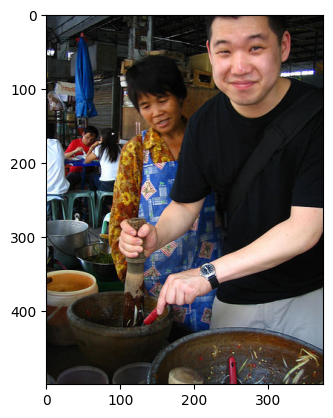

In [5]:
print(type(image), type(label))
print(image, label)

plt.imshow(image)
plt.show()

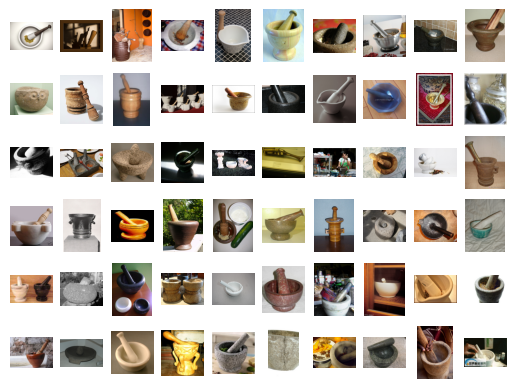

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(exp[index][0])

In [7]:
to_tensor = transforms.ToTensor()
image_t = to_tensor(image)
image_t.shape

torch.Size([3, 500, 375])

In [8]:
del exp

### Convert to DataSet to Tensor

In [9]:
simple_transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(256),
                transforms.ToTensor()])
                                      
exp_t = ImageNetKaggle("/home/shivamkhaneja1/data/imagenet/", "train", transform=simple_transform)

image_t,_ = exp_t[9999]

print('IsTensor:', type(image_t))
print('Shape:', image_t.shape)
print('DataType:', image_t.dtype)
print('Min:', image_t.min())
print('Max:', image_t.max())

IsTensor: <class 'torch.Tensor'>
Shape: torch.Size([3, 256, 256])
DataType: torch.float32
Min: tensor(0.0275)
Max: tensor(1.)


Invalid shape (3, 256, 256) for image data
torch.Size([3, 256, 256]) torch.Size([256, 256, 3])


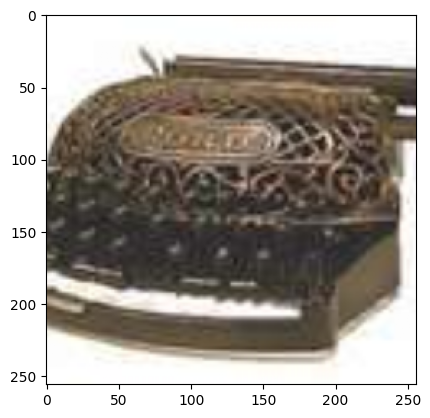

In [10]:
try:
    plt.imshow(image_t)
except Exception as e:
    print(e)
print(image_t.shape, image_t.permute(1,2,0).shape)
plt.imshow(image_t.permute(1,2,0))
plt.show()

It checks. Note how we have to use permute to change the order of the axes from C × H × W to H × W × C to match what Matplotlib expects.

## 3. Calculate Mean & Standard Deviation per Channel

In [12]:
images = torch.stack([image_t for image_t,_ in [exp_t[index] for index in range(0, 100)]], dim=3)
images.shape

torch.Size([3, 256, 256, 100])

In [13]:
images.view(3,-1).mean(dim=1)

tensor([0.5285, 0.4774, 0.4165])

Recall that view(3, -1) keeps the three channels and merges all the remaining dimensions into one, figuring out the appropriate size. Here our 3 × 32 × 32 image is transformed into a 3 × 1,024 vector, and then the mean is taken over the 1,024 elements of each channel.

## 3.1 Record Some Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [18]:
image, label = next(iter(exp_t))

print('[Train]')
print(' - Numpy Shape:', exp_t[999][0].shape)
print(' - DataSet Length:', len(exp_t))
print(' - Tensor Shape:', image.size())
print(' - min:', images.view(3,-1).min(dim=1))
print(' - max:', images.view(3,-1).max(dim=1))
print(' - mean:', images.view(3,-1).mean(dim=1))
print(' - std:', images.view(3,-1).std(dim=1))
print(' - var:', images.view(3,-1).var(dim=1))

[Train]
 - Numpy Shape: torch.Size([3, 256, 256])
 - DataSet Length: 1281167
 - Tensor Shape: torch.Size([3, 256, 256])
 - min: torch.return_types.min(
values=tensor([0., 0., 0.]),
indices=tensor([24, 24, 24]))
 - max: torch.return_types.max(
values=tensor([1., 1., 1.]),
indices=tensor([0, 0, 0]))
 - mean: tensor([0.5285, 0.4774, 0.4165])
 - std: tensor([0.2827, 0.2765, 0.2852])
 - var: tensor([0.0799, 0.0765, 0.0813])


In [21]:
del images, exp_t

## 4. Import & Define Train/Test Data with Normalized Tensors

1.   Define Appropriate Transformations
2.   Apply the Transformations to Input Dataset - both Train & Test


In [78]:
torch.cuda.empty_cache()
import gc
gc.collect()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 3            |        cudaMalloc retries: 4         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      | 297652 KiB |  14577 MiB |  79013 MiB |  78722 MiB |\n|       from large pool | 261760 KiB |  14528 MiB |  78580 MiB |  78324 MiB |\n|       from small pool |  35892 KiB |     73 MiB |    433 MiB |    397 MiB |\n|---------------------------------------------------------------------------|\n| Active memory         | 297652 KiB |  14577 MiB |  79013 MiB |  78722 MiB |\n|       from large pool | 261760 KiB |  14528 MiB |

In [79]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

# Train Phase transformations
train_transforms = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)])

# Val Phase transformations
val_transforms = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)])

In [80]:
train = ImageNetKaggle("/home/shivamkhaneja1/data/imagenet/", "train", transform=train_transforms)
val = ImageNetKaggle("/home/shivamkhaneja1/data/imagenet/", "val", transform=val_transforms)

### Review that Mean=0 and Std Deviation=1 after Normalization

In [81]:
images = torch.stack([image_t for image_t,_ in [train[index] for index in range(0, 100)]], dim=3)
images.shape

image, label = next(iter(train))

print('[Train]')
print(' - Numpy Shape:', train[999][0].shape)
print(' - DataSet Length:', len(train))
print(' - Tensor Shape:', image.size())
print(' - min:', images.view(3,-1).min(dim=1))
print(' - max:', images.view(3,-1).max(dim=1))
print(' - mean:', images.view(3,-1).mean(dim=1))
print(' - std:', images.view(3,-1).std(dim=1))
print(' - var:', images.view(3,-1).var(dim=1))

[Train]
 - Numpy Shape: torch.Size([3, 224, 224])
 - DataSet Length: 1281167
 - Tensor Shape: torch.Size([3, 224, 224])
 - min: torch.return_types.min(
values=tensor([-2.1179, -2.0357, -1.8044]),
indices=tensor([24, 24, 24]))
 - max: torch.return_types.max(
values=tensor([2.2489, 2.4286, 2.6400]),
indices=tensor([ 0,  0, 50]))
 - mean: tensor([ 0.1663,  0.0626, -0.0037])
 - std: tensor([1.2108, 1.2027, 1.2297])
 - var: tensor([1.4659, 1.4466, 1.5121])


Mean is very close to zero and Standard Deviation is close to 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4210021..2.64].


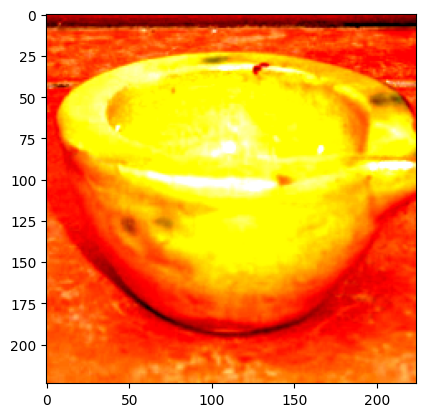

In [82]:
image_t , _ = train[99]

plt.imshow(image_t.permute(1,2,0))

plt.show()

This is because normalization has shifted the RGB levels outside the 0.0 to 1.0 range and changed the overall magnitudes of the channels. All of the data is still there; it’s just that Matplotlib renders it as black. We’ll keep this in mind for the future.

## 5. Define your NN Model

In [83]:
model = ResNet50(len(train.syn_to_class)).to('cuda')
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (i_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, m

In [84]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = model.to(device)
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,160
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,928
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,640
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,640
      BatchNorm2d-14          [-1, 256,

## 7. SEED - finish randomness of PyTorch

Before we start training, get rid of PyTorch SEED Issue

In [85]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


## 8. Create Dataset Batches

In [86]:

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=96, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# val dataloader
val_loader = torch.utils.data.DataLoader(val, **dataloader_args)

## 9. Define Training and Testing Methods for Neural Network

In [92]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

# Initialize the GradScaler for mixed precision training
scaler = GradScaler()

def train(model, device, train_loader, optimizer, epoch, scheduler):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        y_pred = model(data)

        loss = F.nll_loss(y_pred, target)

        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_losses.append(loss.item)

def validate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

## 10. Run, Train and Test the Model

In [93]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

EPOCHS = 1
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, scheduler)
    validate(model, device, val_loader)

EPOCH: 0


Epoch 0: 100%|██████████████████████████████| 13346/13346 [1:30:50<00:00,  2.45it/s, loss=4.95, acc=11.8, lr=0.1]



Test set: Average loss: -6.2542, Accuracy: 9279/50000 (18.56%)



In [81]:

EPOCHS = 1
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    avg_loss = sum(train_losses)/len(train_losses)
    scheduler.step(avg_loss)
    validate(model, device, val_loader)

EPOCH: 0


Loss=nan Batch_id=4054 Accuracy=0.10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4055/4055 [27:07<00:00,  2.49it/s]



Test set: Average loss: nan, Accuracy: 50/50000 (0.10%)

